# MOVE Tutorial

1. [Data Pre-Processing](#Data-Pre-Processing)
2. [Training](#Training)
3. [Post-Analysis](#Post-Analysis)
    1. [Reconstruction Accuracy](#Reconstruction-Accuracy)
    2. [Latent Representation](#Latent-Representation)
    3. [Feature Importance](#Feature-Importance)

In this tutorial, we will use MOVE to integrate microbiome census data and environmental data. We will use a dataset taken from [Walters et al. (2018)](https://www.pnas.org/doi/10.1073/pnas.1800918115), consisting of the soil microbiome of different varieties of maize.

## Data Pre-Processing

First step is to pre-process our data. But first we will download the datasets.

In [1]:
from math import sqrt

import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity

import plot_importance
import maize_dataset
from VAE_v2_1 import VAE, concat_cat_list, concat_con_list, Dataset

The `maize_metadata` dataset contains the following continuous features:

- plant age (weeks),
- rain (inches, accumulation 3 previous days), and
- temperature (&deg;F)

and categorical features:

- maize line (6 classes) and
- maize variety (27 classes).

In [2]:
metadata_path = maize_dataset.fetch("maize_metadata", "data/maize_metadata.csv")

metadata = pd.read_csv(metadata_path, sep="\t").set_index("X.SampleID")
metadata[["age", "Temperature", "Precipitation3Days", "INBREDS", "Maize_Line"]].head()

,age,Temperature,Precipitation3Days,INBREDS,Maize_Line
X.SampleID,,,,,
11116.C02A66.1194587,12,76.0,0.14,Oh7B,Non_Stiff_Stalk
11116.C06A63.1195666,12,76.0,0.14,P39,Sweet_Corn
11116.C08A61.1197689,12,76.0,0.14,CML333,Tropical
11116.C08A63.1196825,12,76.0,0.14,CML333,Tropical
11116.C12A64.1197667,12,76.0,0.14,Il14H,Sweet_Corn


The `maize_microbiome` dataset contains 717 operational taxonomic units (OTUs).

Note that some samples do not have OTUs, so we will remove them from the analysis.

In [3]:
microbiome_path = maize_dataset.fetch("maize_microbiome", "data/maize_microbiome.csv")

otu_data = pd.read_csv(microbiome_path, sep="\t", index_col=0)
otu_data = otu_data.loc[:, lambda x: x.sum(axis=0) > 1]  # drop samples without taxa

samples = otu_data.columns  # samples to keep

otu_data.head()

,11116.C02A66.1194587,11116.C06A63.1195666,11116.C08A61.1197689,11116.C08A63.1196825,11116.C12A64.1197667,11116.C32A64.1196963,11116.I04A072.1197342,11116.I04A081.1193959,11116.I05A090.1197583,11116.I07A071.1194207,...,11116.I11A096.1194018,11116.L21A088.1197969,11116.L22A085.1195257,11116.A06D079.1194326,11116.L23A075.1195736,11116.I32A070.1195285,11116.A15D085.1195787,11116.A23D094.1195481,11116.A15D097.1198211,11116.A04B094.1196153
otuids,,,,,,,,,,,,,,,,,,,,,
4479944,70,8,18,24,22,34,0,6,12,4,...,0,0,0,0,0,0,0,0,0,0
513055,2,16,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
519510,22,15,12,30,33,46,12,1,8,108,...,0,0,0,0,0,0,0,0,0,0
810959,5,0,3,1,6,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
849092,5,2,1,3,5,10,10,442,732,5,...,0,0,0,0,0,0,0,0,0,0


The continuous environment variables are scaled, whereas the categorical features are one hot encoded.

In [4]:
cont_metadata = maize_dataset.scale(metadata.loc[samples, ["age", "Temperature", "Precipitation3Days"]].values)
np.save("data/maize_cont.npy", cont_metadata)

line_data = pd.get_dummies(metadata.loc[samples, "Maize_Line"]).values[:, np.newaxis, :]
np.save("data/maize_line.npy", line_data)

variety_data = pd.get_dummies(metadata.loc[samples, "INBREDS"]).values[:, np.newaxis, :]
np.save("data/maize_variety.npy", variety_data)

For the OTU table, we perform log-centered ratio transformation.

In [5]:
otu_table = otu_data.values

otu_table = maize_dataset.rclr(otu_table).T
otu_table[np.isnan(otu_table)] = 0  # Replace NaN with 0

np.save("data/maize_otu.npy", variety_data)

We create a PyTorch dataset and dataloader.

In [6]:
# Concatenate input data
cat_list = [line_data, variety_data]
con_list = [cont_metadata, otu_table]

cat_shapes, mask, cat_all = concat_cat_list(cat_list)
con_shapes, mask, con_all = concat_con_list(con_list, mask)

dataset = Dataset(
    torch.from_numpy(cat_all).float(),
    torch.from_numpy(con_all).float(),
    con_shapes,
    cat_shapes
)
train_dataloader = torch.utils.data.DataLoader(dataset, 10, drop_last=True, shuffle=True)

# Count number of categorical and continuous features
ncategorical = cat_all.shape[1]
ncontinuous = con_all.shape[1]

## Training

We initialize our model. Here we define hyperparameters such as number of hidden units, layers, or weights for the features.

In [7]:
model = VAE(
    ncategorical=ncategorical, ncontinuous=ncontinuous, 
    con_shapes=con_shapes, cat_shapes=cat_shapes,
    nhiddens=[200], nlatent=20, beta=0.0001, 
    cat_weights=[1, 1], con_weights=[1, 1],
    dropout=0.2,
    cuda=False
)

num_params = sum([p.numel() for p in model.parameters() if p.requires_grad])
print(f"The model has {num_params:,} trainable parameters.")

The model has 315,193 trainable parameters.


Set the training parameters. We will only train for 20 epochs.

In [8]:
# Training parameters
nepochs = 20
epochs = [i + 1 for i in range(nepochs)]
lrate = 0.0001
kld_w = 0

# Lists for saving the results
losses = list()
ce = list()
sse = list()
KLD = list()

In [9]:
# Training the model
for epoch in epochs:
    l, c, s, k = model.encoding(train_dataloader, epoch, lrate, kld_w)

    losses.append(l)
    ce.append(c)
    sse.append(s)
    KLD.append(k)

	Epoch: 1	Loss: 7.293656	CE: 5.2680779	SSE: 2.025579	KLD: 0.0000	Batchsize: 10
	Epoch: 2	Loss: 6.727972	CE: 5.0739664	SSE: 1.654005	KLD: 0.0000	Batchsize: 10
	Epoch: 3	Loss: 6.334161	CE: 4.8877238	SSE: 1.446438	KLD: 0.0000	Batchsize: 10
	Epoch: 4	Loss: 5.917874	CE: 4.6350135	SSE: 1.282860	KLD: 0.0000	Batchsize: 10
	Epoch: 5	Loss: 5.358610	CE: 4.1881222	SSE: 1.170487	KLD: 0.0000	Batchsize: 10
	Epoch: 6	Loss: 4.756773	CE: 3.6538802	SSE: 1.102893	KLD: 0.0000	Batchsize: 10
	Epoch: 7	Loss: 4.316040	CE: 3.2405205	SSE: 1.075519	KLD: 0.0000	Batchsize: 10
	Epoch: 8	Loss: 3.962998	CE: 2.9296952	SSE: 1.033303	KLD: 0.0000	Batchsize: 10
	Epoch: 9	Loss: 3.659991	CE: 2.6538389	SSE: 1.006152	KLD: 0.0000	Batchsize: 10
	Epoch: 10	Loss: 3.398826	CE: 2.4072358	SSE: 0.991590	KLD: 0.0000	Batchsize: 10
	Epoch: 11	Loss: 3.188672	CE: 2.2114216	SSE: 0.977250	KLD: 0.0000	Batchsize: 10
	Epoch: 12	Loss: 2.981930	CE: 2.0374272	SSE: 0.944503	KLD: 0.0000	Batchsize: 10
	Epoch: 13	Loss: 2.843803	CE: 1.9202454	SSE: 0.92

We now plot the overall loss, as well as the continuous (MSE) and categorical error (cross entropy).

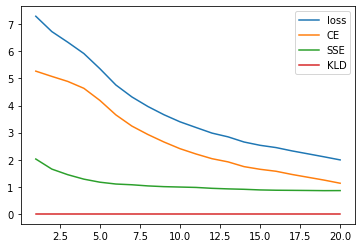

In [11]:
# Plot training error
fig, ax = plt.subplots()

ax.plot(epochs, losses, label='loss')
ax.plot(epochs, ce, label='CE')
ax.plot(epochs, sse, label='SSE')
ax.plot(epochs, KLD, label='KLD')
ax.legend()

plt.show()

## Post-Analysis

Now, we analyze the results. First, let's use the trained model to get reconstructions and embeddings.

In [12]:
test_dataloader = torch.utils.data.DataLoader(train_dataloader.dataset, 1, shuffle=False)

latent, latent_var, cat_recon, cat_class, con_recon, loss, likelihood = model.latent(test_dataloader, kld_w)

====> Test set loss: 1.4237


### Reconstruction Accuracy

We will now calculate the accuracy of the reconstructions. For categorical variables, we just count the number of matching classes between input and reconstruction. For continous variables, we use cosine similarity.

In [13]:
# Calculate the categorical reconstruction accuracy
cat_true_recon = []
cat_total_recon = []
pos = 0
for s in cat_shapes:
    n = s[1]
    cat_class_tmp = cat_class[:,pos:(n + pos)]
    cat_recon_tmp = cat_recon[:,pos:(n + pos)]

    missing_cat = cat_recon_tmp[cat_class_tmp == -1]
    diff_cat = cat_class_tmp - cat_recon_tmp

    diff_cat[diff_cat != 0] = -1
    true_cat = diff_cat[diff_cat == 0]
    false_cat = diff_cat[diff_cat != 0]
    cat_true = len(true_cat) / (float(diff_cat.size) - missing_cat.size)
    cat_true_recon.append(cat_true)
    diff_cat[diff_cat == 0] = 1
    diff_cat[diff_cat != 1] = 0
    cat_total_recon.append(np.count_nonzero(diff_cat, 1) / diff_cat.shape[1])
    pos += n

# Calculate the continuous reconstruction accuracy
total_shape = 0
true_recon = []
cos_values = []
all_values = []
for s in con_shapes:
    cos_con = list()
    all_val = list()
    for n in range(0, con_recon.shape[0]):
        con_no_missing = train_dataloader.dataset.con_all[n,total_shape:(s + total_shape - 1)][train_dataloader.dataset.con_all[n,total_shape:(s + total_shape - 1)] != 0]
        if len(con_no_missing) <= 1:
            all_val.append(np.nan)
            continue
        con_out_no_missing = con_recon[n,total_shape:(s + total_shape - 1)][train_dataloader.dataset.con_all[n,total_shape:(s + total_shape - 1)] != 0]

        com = np.vstack([con_no_missing, con_out_no_missing])
        cos = cosine_similarity(com)[0,1]
        cos_con.append(cos)
        all_val.append(cos)

    cos_con = np.array(cos_con)
    cos_values.append(cos_con)
    all_values.append(np.array(all_val))
    true_recon.append(len(cos_con[cos_con >= 0.9]) / len(cos_con))
    total_shape += s

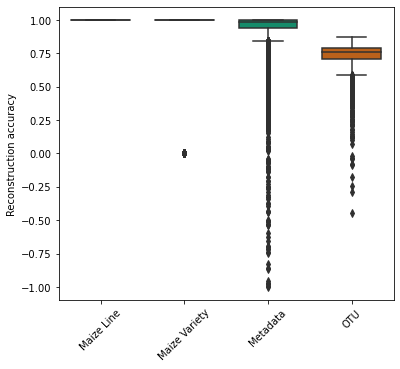

In [14]:
df = pd.DataFrame(cat_total_recon + all_values, index=["Maize Line", "Maize Variety", "Metadata", "OTU"])

fig = plt.figure(figsize=(6,6))
ax = sns.boxplot(data=df.T, palette="colorblind", width=0.7)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
ax.set_ylabel('Reconstruction accuracy')
fig.subplots_adjust(bottom=0.2)

plt.show()

### Latent Representation

A plus of using VAEs is that the latent representation that we get clusters the input for us. We will check if the clusters make sense in terms of the categorical data.

Since our latent space has 20 dimensions, we will use t-SNE to reduce it to a bidimensional space that we can easily visualize.

In [17]:
embedder = TSNE(init="pca", perplexity=int(sqrt(latent.shape[0])), learning_rate="auto")

z = latent + np.exp(0.5 * latent_var)

z_embed = embedder.fit_transform(z)

C:\Users\zqw270\Anaconda3\envs\dl\lib\site-packages\sklearn\manifold\_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


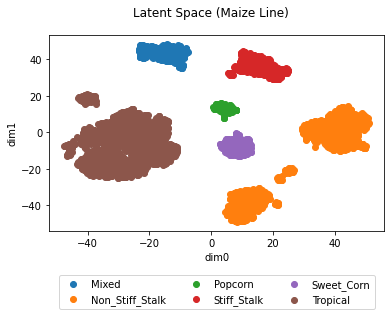

In [18]:
lines = pd.Series(pd.Categorical(metadata.loc[samples, "Maize_Line"])).sort_values()

fig, ax = plt.subplots()

for cat in lines.cat.categories:
    ids = lines.where(lambda x: x == cat).dropna().index.values
    ax.scatter(z_embed[ids,0], z_embed[ids, 1], label=cat)

box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
    
fig.suptitle("Latent Space (Maize Line)")
ax.set(xlabel="dim0", ylabel="dim1")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3)

plt.show()

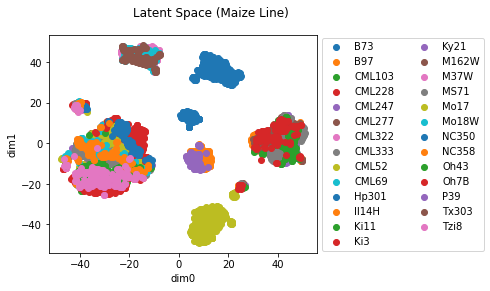

In [19]:
varieties = pd.Series(pd.Categorical(metadata.loc[samples, "INBREDS"])).sort_values()

fig, ax = plt.subplots()

for cat in varieties.cat.categories:
    ids = varieties.where(lambda x: x == cat).dropna().index.values
    ax.scatter(z_embed[ids,0], z_embed[ids, 1], label=cat)

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    
fig.suptitle("Latent Space (Maize Line)")
ax.set(xlabel="dim0", ylabel="dim1")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), ncol=2)

plt.show()

### Feature Importance

Lastly, we will calculate feature importance. For this, we make continuous features zero, recalculate the latent space, and compare the differences.

In [20]:
# Feature importance continuous
all_diffs_con = []
sum_diffs_con = []
sum_diffs_con_abs = []
total_diffs_con = []
loss_con = []
con_shape = train_dataloader.dataset.con_all.shape[1]

for feature_index in range(con_shape):
    
    new_con = np.array(train_dataloader.dataset.con_all)
    new_con[:,feature_index] = 0
    new_con = torch.from_numpy(new_con)
    
    dataset = Dataset(train_dataloader.dataset.cat_all, new_con,
                      train_dataloader.dataset.con_shapes,
                      train_dataloader.dataset.cat_shapes)
    
    new_loader = torch.utils.data.DataLoader(dataset, batch_size=len(mask), drop_last=False,
                                             shuffle=False, num_workers=1, 
                                             pin_memory=train_dataloader.pin_memory)
    
    out = model.latent(new_loader, kld_w)
    
    new_latent_vector = out[0]
    loss_con.append(out[-1])
    diff_abs = np.abs(latent - new_latent_vector)
    diff = latent - new_latent_vector
    all_diffs_con.append(diff)
    sum_diffs_con.append(np.sum(diff, axis = 1))
    sum_diffs_con_abs.append(np.sum(diff_abs, axis = 1))
    total_diffs_con.append(np.sum(diff))
    
all_diffs_con_np = np.asarray(all_diffs_con)
sum_diffs_con_np = np.asarray(sum_diffs_con)
sum_diffs_con_abs_np = np.asarray(sum_diffs_con_abs)
total_diffs_con_np = np.asarray(total_diffs_con)

====> Test set loss: 1.5040
====> Test set loss: 1.4389
====> Test set loss: 1.4299
====> Test set loss: 1.4274
====> Test set loss: 1.4263
====> Test set loss: 1.4259
====> Test set loss: 1.4260
====> Test set loss: 1.4317
====> Test set loss: 1.4261
====> Test set loss: 1.4263
====> Test set loss: 1.4225
====> Test set loss: 1.4267
====> Test set loss: 1.4247
====> Test set loss: 1.4263
====> Test set loss: 1.4272
====> Test set loss: 1.4251
====> Test set loss: 1.4282
====> Test set loss: 1.4224
====> Test set loss: 1.4268
====> Test set loss: 1.4271
====> Test set loss: 1.4267
====> Test set loss: 1.4278
====> Test set loss: 1.4247
====> Test set loss: 1.4297
====> Test set loss: 1.4248
====> Test set loss: 1.4258
====> Test set loss: 1.4322
====> Test set loss: 1.4254
====> Test set loss: 1.4261
====> Test set loss: 1.4253
====> Test set loss: 1.4267
====> Test set loss: 1.4304
====> Test set loss: 1.4300
====> Test set loss: 1.4255
====> Test set loss: 1.4266
====> Test set loss:

====> Test set loss: 1.4274
====> Test set loss: 1.4253
====> Test set loss: 1.4254
====> Test set loss: 1.4221
====> Test set loss: 1.4247
====> Test set loss: 1.4251
====> Test set loss: 1.4295
====> Test set loss: 1.4255
====> Test set loss: 1.4239
====> Test set loss: 1.4251
====> Test set loss: 1.4268
====> Test set loss: 1.4268
====> Test set loss: 1.4250
====> Test set loss: 1.4274
====> Test set loss: 1.4258
====> Test set loss: 1.4243
====> Test set loss: 1.4328
====> Test set loss: 1.4238
====> Test set loss: 1.4253
====> Test set loss: 1.4305
====> Test set loss: 1.4293
====> Test set loss: 1.4260
====> Test set loss: 1.4254
====> Test set loss: 1.4249
====> Test set loss: 1.4242
====> Test set loss: 1.4242
====> Test set loss: 1.4271
====> Test set loss: 1.4262
====> Test set loss: 1.4273
====> Test set loss: 1.4261
====> Test set loss: 1.4232
====> Test set loss: 1.4301
====> Test set loss: 1.4271
====> Test set loss: 1.4176
====> Test set loss: 1.4256
====> Test set loss:

====> Test set loss: 1.4283
====> Test set loss: 1.4314
====> Test set loss: 1.4237
====> Test set loss: 1.4277
====> Test set loss: 1.4277
====> Test set loss: 1.4231
====> Test set loss: 1.4250
====> Test set loss: 1.4242
====> Test set loss: 1.4260
====> Test set loss: 1.4277
====> Test set loss: 1.4274
====> Test set loss: 1.4261
====> Test set loss: 1.4260
====> Test set loss: 1.4249
====> Test set loss: 1.4262
====> Test set loss: 1.4257
====> Test set loss: 1.4218
====> Test set loss: 1.4254
====> Test set loss: 1.4230
====> Test set loss: 1.4298
====> Test set loss: 1.4265
====> Test set loss: 1.4262
====> Test set loss: 1.4277
====> Test set loss: 1.4273
====> Test set loss: 1.4309
====> Test set loss: 1.4254
====> Test set loss: 1.4272
====> Test set loss: 1.4248
====> Test set loss: 1.4235
====> Test set loss: 1.4213
====> Test set loss: 1.4268
====> Test set loss: 1.4463
====> Test set loss: 1.4250
====> Test set loss: 1.4239
====> Test set loss: 1.4227
====> Test set loss:

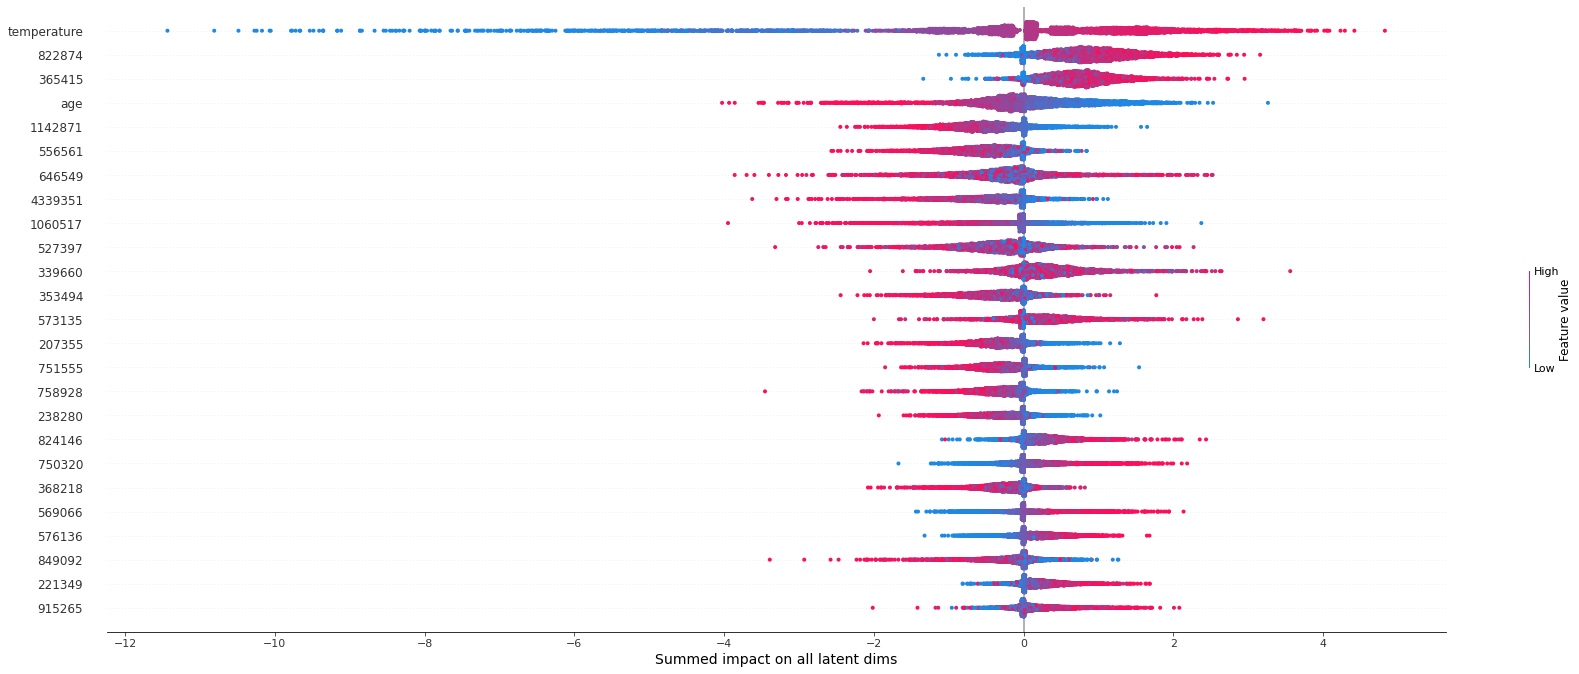

In [21]:
# Plot continuous
con_names = ["age", "temperature", "precipitation", *map(str, otu_data.index.values)]

con_all = np.asarray(train_dataloader.dataset.con_all)
sum_diffs_con_np = np.transpose(sum_diffs_con_np)

fig = plt.figure(figsize = (20,20))
p = plot_importance.summary_plot(sum_diffs_con_np, features=con_all, 
                                 feature_names=con_names, max_display = 25,
                                 size = 30)